# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filenames1 = ['ccbar0','phi0']
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [3]:
if True:
    data = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        data = pd.concat([data,idata], sort=False)

    data = data.sample(frac = 1)
    float_columns=('Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore',\
                   'sdphi0','sdthe0','SecondHitPhiR0','SecondHitPhiL0','SecondHitTheR0','SecondHitTheL0',\
                   'sdphi1','sdthe1','SecondHitPhiR1','SecondHitPhiL1','SecondHitTheR1','SecondHitTheL1',\
                   'sdphi2','sdthe2','SecondHitPhiR2','SecondHitPhiL2','SecondHitTheR2','SecondHitTheL2',\
                   'sdphi3','sdthe3','SecondHitPhiR3','SecondHitPhiL3','SecondHitTheR3','SecondHitTheL3')
    int_columns=('NBDThit','Centrality', 'Charge', 'Arm','IsTrue0','IsTrue1','IsTrue2','IsTrue3')
    
    for float_column in float_columns:
        data[float_column] = data[float_column].astype('float32')
    for int_column in int_columns:
        data[int_column] = data[int_column].astype('int32')
    data.head()
    
    data = data[(data['Pt'] < 25) & (data['Ecore'] > 0.1) & (data['Ecore'] < 25) ]
    
    data.loc[idata['sdphi2'] == -10, 'IsTrue2'] = 1
    data.loc[idata['sdphi3'] == -10, 'IsTrue3'] = 1
    data['IsTrue0'] = data['IsTrue0']*data['IsTrue1'] * data['IsTrue2']*data['IsTrue3']
    data.loc[idata['IsTrue0'] > 0, 'IsTrue0'] = 1
    data.head()

In [4]:
data.head()

NBDThit        Pt      Phi0      The0     PhiDC        ZDC     Alpha  \
3234070        3  0.186355 -0.799018  1.432617  0.433838  31.101166 -0.583008   
4737686        6  5.348000  3.592000  1.819000  3.633000 -56.279999 -0.020070   
7620036        3  2.934000  3.623000  1.575000  3.555000  -1.039000  0.034900   
5131059        6  0.492262  0.015783  1.229492 -0.420410  76.993744  0.228394   
5635475        3  1.085000  0.683000  1.472000  0.873000  21.610001 -0.096100   

            Ecore  Centrality  Charge  ...  SecondHitPhiL2  SecondHitTheR2  \
3234070  0.214711          70       1  ...      -99.000000        5.890168   
4737686  5.473000          92       1  ...      -99.000000       44.840000   
7620036  2.367000          23      -1  ...       10.055000      -13.266000   
5131059  0.658499          31      -1  ...        2.644238       -5.733203   
5635475  1.078000          51       1  ...      355.000000      -68.940002   

         SecondHitTheL2   sdphi3    sdthe3  IsTrue3  SecondHitPhiR3  \
3234070      -99.000000 -10.0000 -10.00000        0         -99.000   
4737686      -99.000000   0.1034   0.05148        1         -99.000   
7620036      -13.445000   3.6070   3.33400        1          13.555   
5131059        7.380613 -10.0000 -10.00000        1         -99.000   
5635475      -69.559998 -10.0000 -10.00000        1         -99.000   

         SecondHitPhiL3  SecondHitTheR3  SecondHitTheL3  
3234070      -99.000000         -99.000      -99.000000  
4737686      -99.000000         -99.000      -99.000000  
7620036        8.870000          -1.598       -1.871000  
5131059      966.958801         -99.000      106.654533  
5635475      -99.000000         -99.000      -99.000000  

[5 rows x 39 columns]

In [5]:
print(data.size, data.shape)

534333306 (13700854, 39)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['IsTrue1','IsTrue2','IsTrue3'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(4, 3, figsize=(15, 6))
    for i, feature in enumerate(['IsTrue0', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore' , 'sdphi0', 'sdphi1', 'sdphi2', 'sdphi3']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


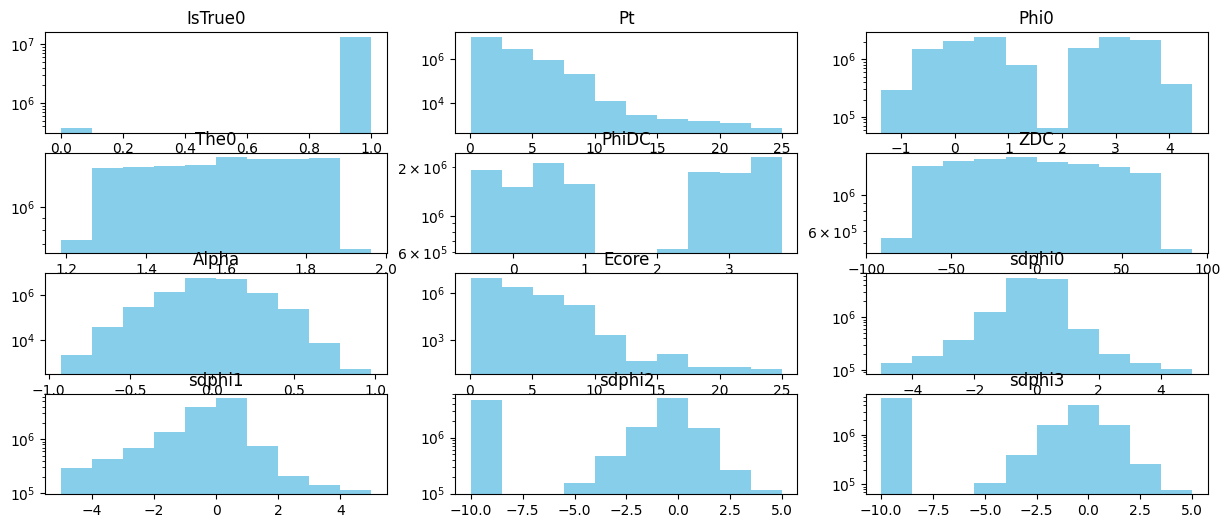

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['IsTrue0']
    data = data.drop(columns = ['IsTrue0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [10]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

4566951 9133903


In [11]:
X_test

NBDThit        Pt      Phi0      The0     PhiDC        ZDC     Alpha  \
802041         3  1.294141  3.061790  1.363281  3.224609  46.199001 -0.082886   
3729921        3  0.386831  2.050269  1.810547  2.619141 -49.910942 -0.282959   
9813721       12  2.398000 -0.066200  1.708000  0.018390 -30.330000 -0.042820   
6889536        3  1.804000 -0.368700  1.392000 -0.482000  39.939999  0.058200   
4176854        3  1.007914 -0.266100  1.643555 -0.468506 -15.823860  0.101929   
...          ...       ...       ...       ...       ...        ...       ...   
3398436        3  0.386500  3.693000  1.543000  3.158000   6.625000  0.265400   
3347939        1  1.184000  3.188000  1.376000  3.016000  43.439999  0.087650   
3559902        3  1.789000  0.113700  1.850000 -0.007427 -62.880001  0.062800   
8682080        3  0.685500  0.217900  1.604500  0.515000  -7.227000 -0.149000   
4038369        3  0.472897 -1.001282  1.728516 -0.563477 -34.446838 -0.219604   

            Ecore  Centrality  Charge  ...  SecondHitPhiR2  SecondHitPhiL2  \
802041   1.246098          55       1  ...      -99.000000      -99.000000   
3729921  0.375339          74       1  ...      -99.000000      -99.000000   
9813721  2.460000           8       1  ...        0.000000        3.998000   
6889536  1.911000          40      -1  ...      -30.860001      153.899994   
4176854  1.044737           7      -1  ...       25.561981       20.008781   
...           ...         ...     ...  ...             ...             ...   
3398436  0.253700          68      -1  ...      -99.000000      -99.000000   
3347939  0.112900          58      -1  ...      -99.000000      -99.000000   
3559902  1.959000           6      -1  ...       -3.967000       11.470000   
8682080  0.502400          51       1  ...      -99.000000      -99.000000   
4038369  0.456319          18       1  ...        0.000000       14.233169   

         SecondHitTheR2  SecondHitTheL2     sdphi3     sdthe3  SecondHitPhiR3  \
802041       -99.000000      -99.000000  -0.751749  -1.373780      -99.000000   
3729921      -99.000000      -99.000000  -1.849320  -0.269877      -99.000000   
9813721        0.000000        5.650000 -10.000000 -10.000000      -99.000000   
6889536       -0.232400       25.219999 -10.000000 -10.000000      -99.000000   
4176854      -11.910622      -12.439103   0.019055  -0.850780       15.228435   
...                 ...             ...        ...        ...             ...   
3398436      -99.000000      -99.000000 -10.000000 -10.000000      -99.000000   
3347939      -99.000000      -99.000000  -0.429200  -0.585400      -99.000000   
3559902       -3.896000       14.760000 -10.000000 -10.000000      -99.000000   
8682080      -99.000000      -99.000000 -10.000000 -10.000000      -99.000000   
4038369      -10.004320       -5.280637 -10.000000 -10.000000      -99.000000   

         SecondHitPhiL3  SecondHitTheR3  SecondHitTheL3  
802041        -99.00000      -99.000000      -99.000000  
3729921       -99.00000      -99.000000      -99.000000  
9813721         1.07800      -99.000000        5.430000  
6889536       154.50000      -99.000000       25.770000  
4176854         6.95497       -7.098278       -7.002028  
...                 ...             ...             ...  
3398436       -99.00000      -99.000000      -99.000000  
3347939       -99.00000      -99.000000      -99.000000  
3559902         4.72300      -99.000000      -11.450000  
8682080       -99.00000      -99.000000      -99.000000  
4038369       -99.00000      -99.000000      -99.000000  

[4566951 rows x 35 columns]

In [12]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [13]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.03      1.00      0.05    124415
           1       1.00      0.01      0.02   4442536

    accuracy                           0.04   4566951
   macro avg       0.51      0.51      0.04   4566951
weighted avg       0.97      0.04      0.02   4566951

confusion matrix
[[ 124415       0]
 [4395704   46832]]


In [14]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[12],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

/home/yoren/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


точность:  0.4770237298363832
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 20}
0.48746329881796413
time of execution (sec) 1224.0773556232452


# Cross Validation

In [15]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.05      1.00      0.09    124415
           1       1.00      0.46      0.63   4442536

    accuracy                           0.48   4566951
   macro avg       0.52      0.73      0.36   4566951
weighted avg       0.97      0.48      0.62   4566951



In [16]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.042778491751871976
roc auc: 0.9523401748893832
f1 score: 0.9799415972471156


Text(0.5, 1.0, 'ROC AUC Curve')

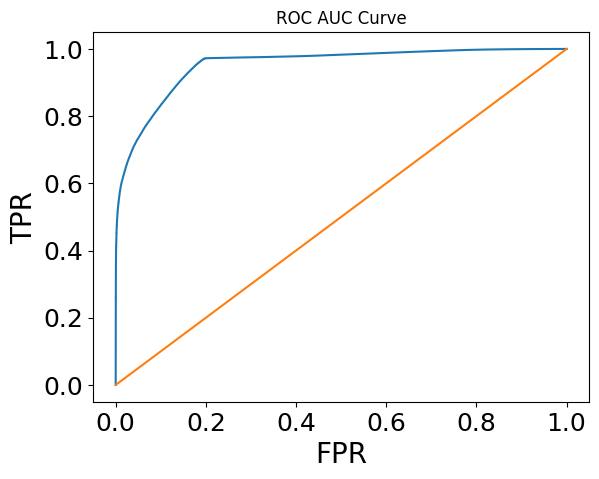

In [17]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [18]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.12502198104314036


In [104]:
i = 380000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.96 0.1922
0.025033406831860713 0.1843909496443355 0.9595402265732905


In [59]:
print(sum(predicted),len(predicted))

2054643 4566951


In [60]:
kek_data = data
kek_data = kek_data.drop(columns = ['IsTrue0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.041156063723307594


In [105]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_Hits_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 50, 0, 5, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 50, 0, 5, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 50, 0, 5, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 50, 0, 5, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 50, 0, 5, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 50, 0, 5, 10, 0, 100)

In [106]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

sigma = 3

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>1000000: break
    sdphi0, sdphi1, sdphi2, sdphi3 = row['sdphi0'], row['sdphi1'], row['sdphi2'], row['sdphi3']
    sdthe0, sdthe1, sdthe2, sdthe3 = row['sdthe0'], row['sdthe1'], row['sdthe2'], row['sdthe3']
    centrality, pt, IsTrue0 = row['Centrality'], row['Pt'], row['IsTrue0']

    if pt<0.4 or centrality<0: continue
    if IsTrue0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if ( abs(sdphi0) < sigma and abs(sdthe0) < sigma and abs(sdphi1) < sigma and abs(sdthe1) < sigma ) and ( ( abs(sdphi2) < sigma and abs(sdthe2) < sigma ) or ( abs(sdphi3) < sigma and abs(sdthe3) < sigma ) ):
        if IsTrue0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if IsTrue0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if IsTrue0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [107]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

857084 48444370.0 0.846 0.283 0.979 0.18 0.184 0.192


In [108]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.822 1.157 0.635 163


In [102]:
%run input/Format.ipynb

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


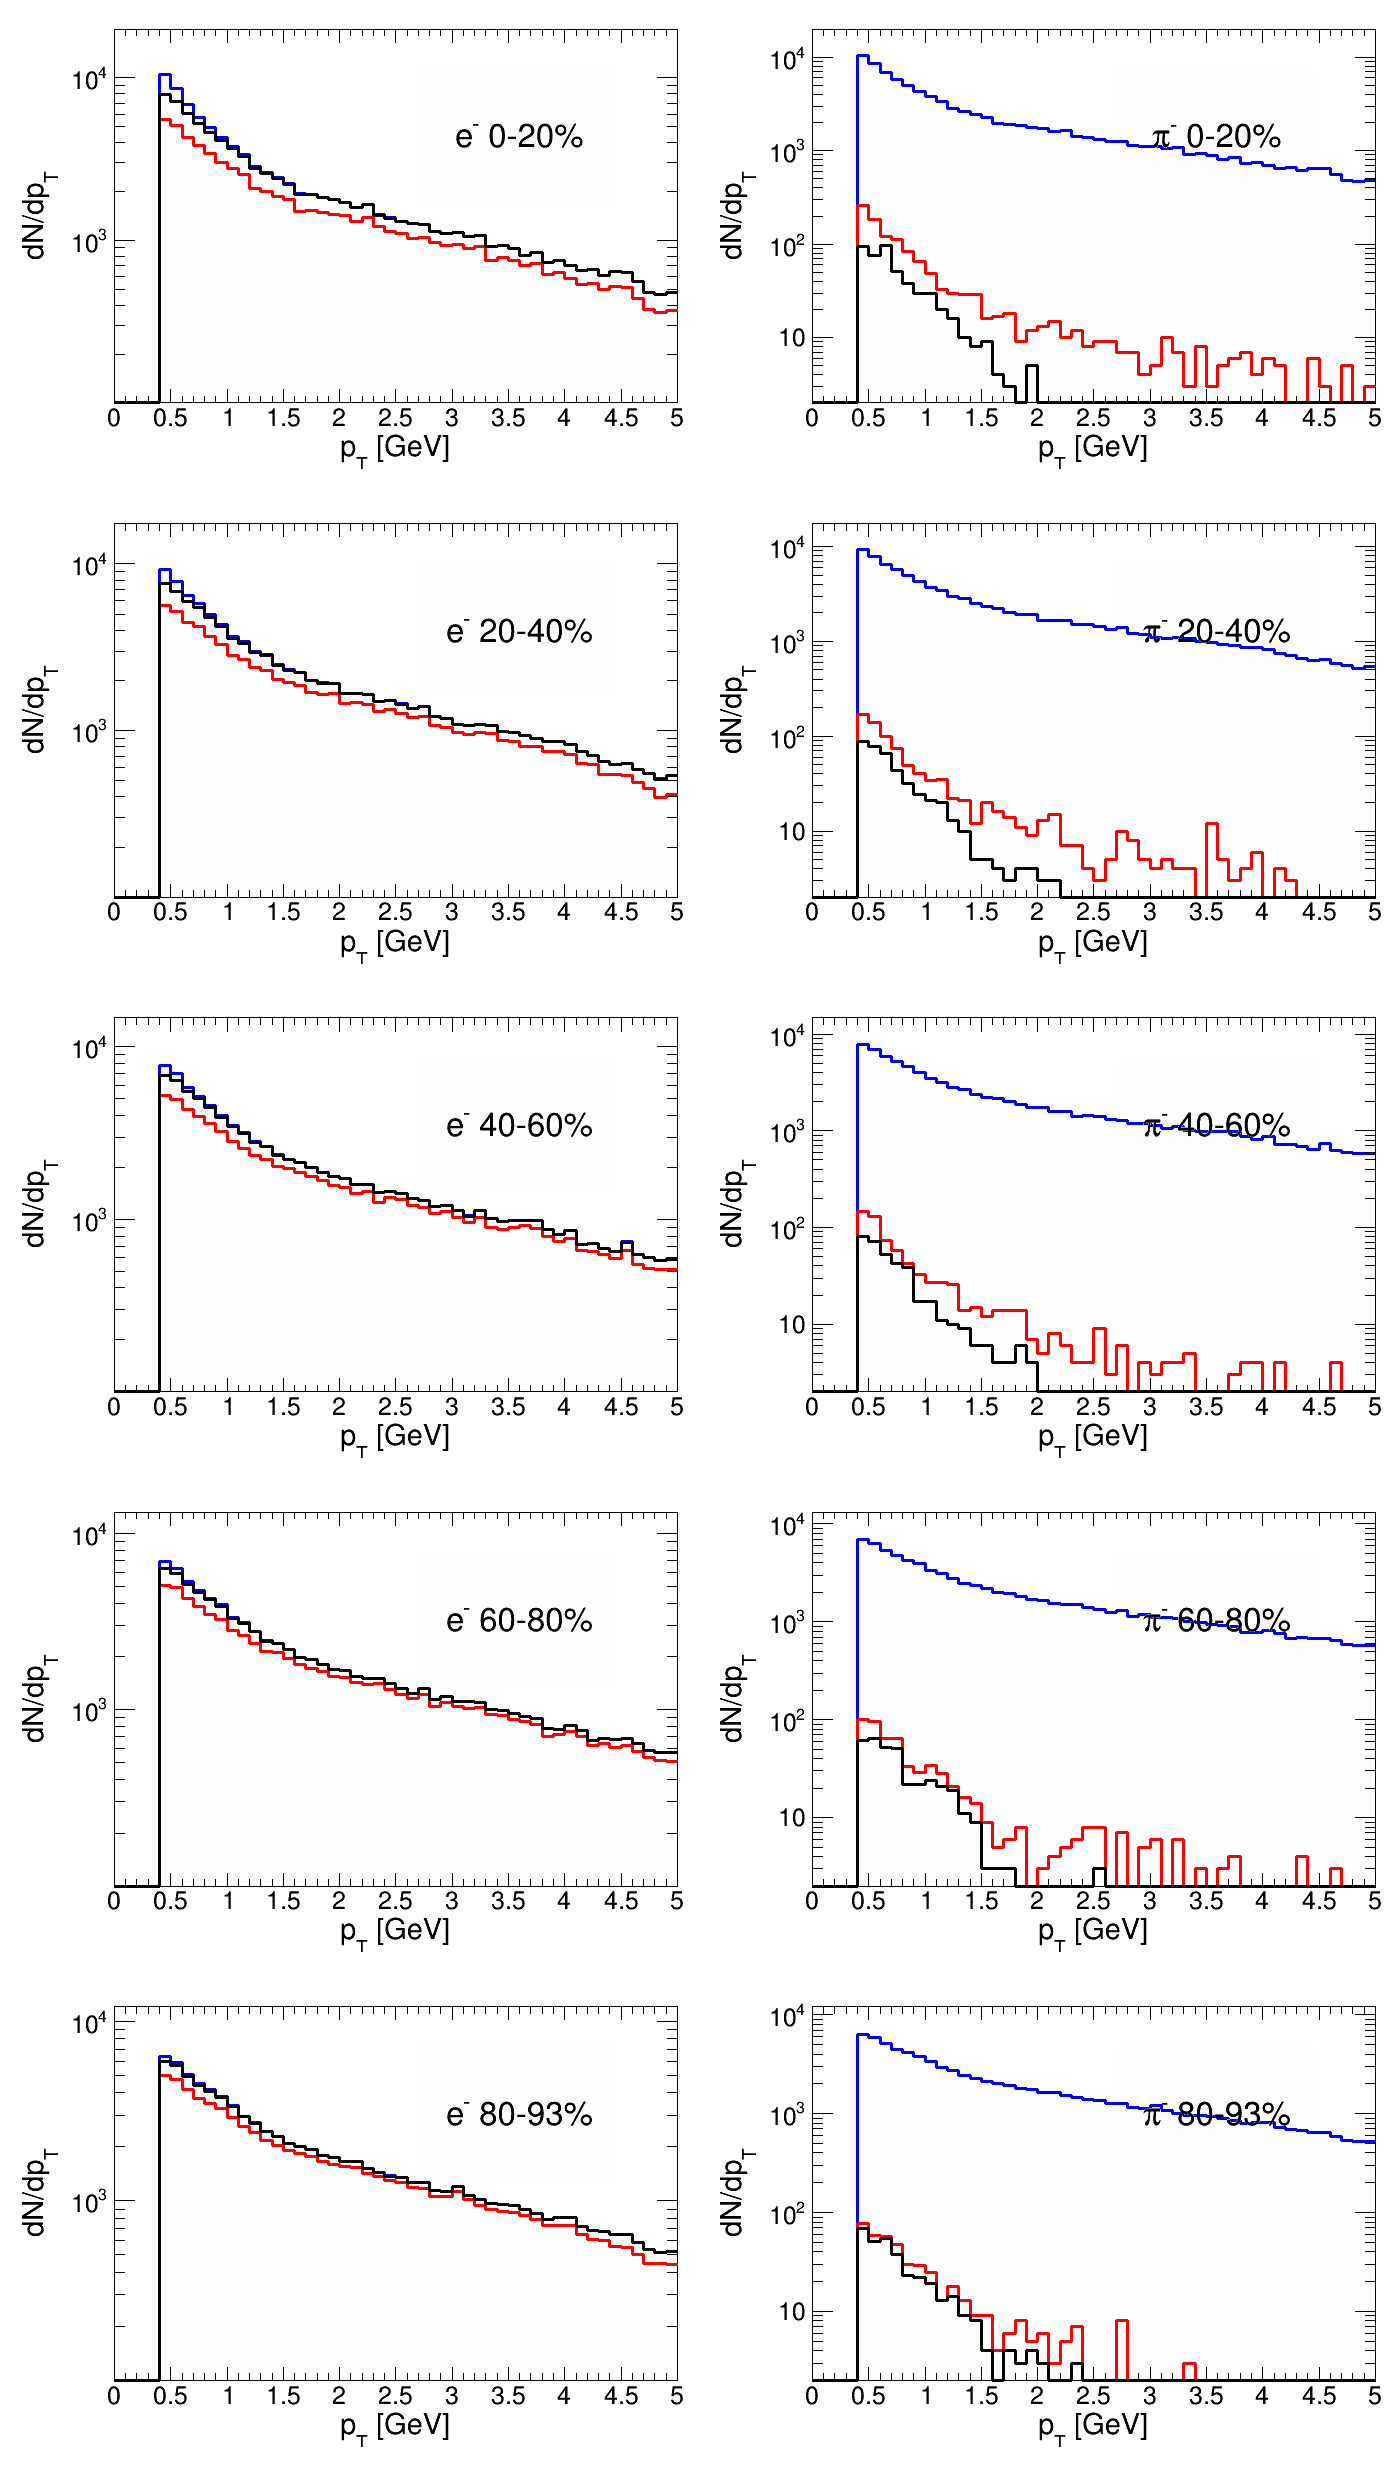

In [109]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "e^{-} " , "#pi^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(3)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",icentr+1,icentr+1)
    proj.SetMinimum(100)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",icentr+1,icentr+1).Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",icentr+1,icentr+1).Draw("same")

    legends.append(Draw_Legend_Title(0.6,0.6,0.9,0.9,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = e_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",icentr+1,icentr+1)
    projh.SetMinimum(100)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",icentr+1,icentr+1).Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",icentr+1,icentr+1).Draw("same")

    legends.append(Draw_Legend_Title(0.6,0.6,0.9,0.9,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].Draw()
c1.Draw()

In [110]:
if True:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [70]:
import pickle
with open('output/bdt_hit.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[0 1 1 0 0 1 0 1 1 1]


In [71]:
import pickle
# load
with open('output/bdt_hit.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[0 1 1 0 0 1 0 1 1 1]


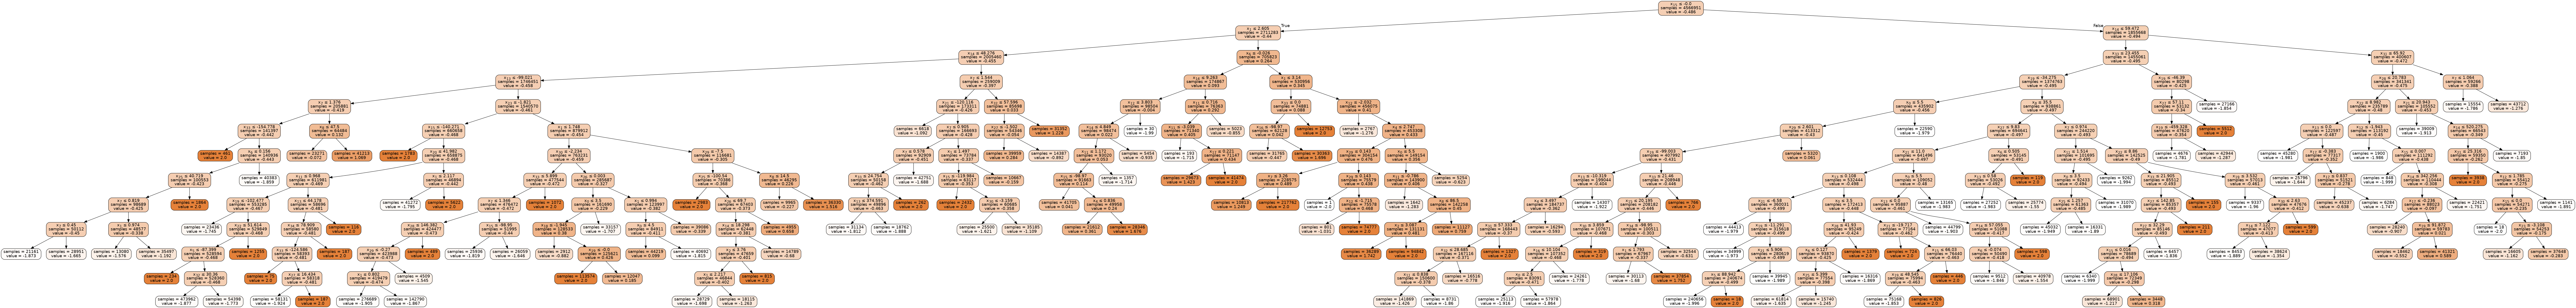

In [72]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [32]:
clf2.predict(kek_data[0:100])

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int32)

In [33]:
clf2.predict_proba(kek_data[0:100])

array([[0.95884394, 0.04115606],
       [0.32003473, 0.67996527],
       [0.14147464, 0.85852536],
       [0.99054143, 0.00945857],
       [0.92718027, 0.07281973],
       [0.05335295, 0.94664705],
       [0.68171738, 0.31828262],
       [0.01360133, 0.98639867],
       [0.03001486, 0.96998514],
       [0.34021917, 0.65978083],
       [0.96666846, 0.03333154],
       [0.97967433, 0.02032567],
       [0.11716798, 0.88283202],
       [0.90236366, 0.09763634],
       [0.11398889, 0.88601111],
       [0.97346455, 0.02653545],
       [0.05493042, 0.94506958],
       [0.08270437, 0.91729563],
       [0.97403504, 0.02596496],
       [0.96882131, 0.03117869],
       [0.96686138, 0.03313862],
       [0.01740952, 0.98259048],
       [0.06788242, 0.93211758],
       [0.0724011 , 0.9275989 ],
       [0.2490953 , 0.7509047 ],
       [0.0258463 , 0.9741537 ],
       [0.96348171, 0.03651829],
       [0.02839819, 0.97160181],
       [0.92859249, 0.07140751],
       [0.99061183, 0.00938817],
       [0.

In [34]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 20}


In [35]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.34021917, 0.65978083],
       [0.96666846, 0.03333154],
       [0.97967433, 0.02032567],
       [0.11716798, 0.88283202],
       [0.90236366, 0.09763634],
       [0.11398889, 0.88601111],
       [0.97346455, 0.02653545],
       [0.05493042, 0.94506958],
       [0.08270437, 0.91729563],
       [0.97403504, 0.02596496],
       [0.96882131, 0.03117869]])

In [36]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-0.31399777 -2.40863456 -2.45364652  1.42227633 -1.81591789  1.12538188
 -2.4388272   1.50944648  1.15625069 -2.4582347 ]
[-3.49255738 -4.02714745 -4.69515461 -3.87874137 -3.01629351 -0.6680954
 -4.2875642  -0.63717184 -3.4939522  -4.19834435 -3.24417264]
[0.42213923 0.08251663 0.0791723  0.80569502 0.13992442 0.75498563
 0.08025944 0.81897916 0.76065078 0.07883844]


In [37]:
best_gbc = clf2.best_estimator_

In [38]:
n_estim = best_gbc.n_estimators

In [39]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 0.66231768 -3.36735142 -3.87533564  2.01952631 -2.22376781  2.05062851
 -3.60237976  2.84519127  2.40615742 -3.62469951]
[0.65978083 0.03333154 0.02032567 0.88283202 0.09763634 0.88601111
 0.02653545 0.94506958 0.91729563 0.02596496]
0.2


In [40]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [41]:
print(log_odds_predictions)

[[0.28402349947826583, -1.8767531393620969, -1.996047536391012, 1.6955847001186746, -1.1922141119221412, 0.04095220610733737, -1.8124421150441672, 2.0, -1.634775490350193, -1.996047536391012], [-1.1644703634157998, -1.54108980523583, -1.6667777323603832, -1.23624519097177, -1.4811942795142676, 0.2385328368231194, -1.582432160763093, 1.4767704655322338, 0.47969649007420967, -1.5635374273236198], [-0.6290911727689775, -1.3660207166266105, -1.3737623311702758, 1.9246174289053848, -1.3297358709345914, 1.054879557958634, -1.3737623311702758, 1.6423096178448076, 1.9246174289053848, -1.3660207166266105], [1.9924422642114108, -1.2488666459054025, -1.2636660918778755, 1.587227290229782, -1.0799484954986662, -1.0374872895746163, -1.2636660918778755, 1.4521855266709354, 1.587227290229782, -1.2636660918778755], [-0.8854178640575775, -1.1428819638280576, -1.1621317821529786, 1.2320795018885486, -1.0322376072379595, 0.09391913448353759, -1.1270643892903336, 0.23499669196443537, 1.6722430871907703, -

In [42]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 -0.31399777471187296
[ 0.66231768 -3.36735142 -3.87533564  2.01952631 -2.22376781  2.05062851
 -3.60237976  2.84519127  2.40615742 -3.62469951]


In [43]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[0.28402349947826583, -1.1644703634157998, -0.6290911727689775, 1.9924422642114108, -0.8854178640575775, -0.4851797301699825, -0.5866445234784183, 0.6984918387677155, -0.48181377834760647, -0.3123290437783944, -0.5253125877924438, -0.3304410854606528, 0.8823683746262316, 0.8503269521100114, 1.7294512899518173, 0.39801870127889727, 0.4327997077906538, -0.5949519574205627, 1.5194697218736342, 0.5198481548483517], [-1.8767531393620969, -1.54108980523583, -1.3660207166266105, -1.2488666459054025, -1.1428819638280576, -1.0596476607291776, -0.972488067858445, -0.8875558754908052, -0.8846589292858911, -1.0632099897234064, -0.5740454624436606, -0.9789332318793039, -0.6719464958949837, -0.48630097572015807, -0.5036462881361221, -0.5044541674213586, -0.33135660489294383, -0.38067583663030763, -0.34228655228415567, -0.0199386853351425], [-1.996047536391012, -1.6667777323603832, -1.3737623311702758, -1.2636660918778755, -1.1621317821529786, -1.0294270791682865, -0.972488067858445, -0.8590572

In [73]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [74]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [75]:
column_headers = list(kek_data.columns.values)
print(column_headers)
print(len(column_headers))

['NBDThit', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore', 'Centrality', 'Charge', 'Arm', 'sdphi0', 'sdthe0', 'SecondHitPhiR0', 'SecondHitPhiL0', 'SecondHitTheR0', 'SecondHitTheL0', 'sdphi1', 'sdthe1', 'SecondHitPhiR1', 'SecondHitPhiL1', 'SecondHitTheR1', 'SecondHitTheL1', 'sdphi2', 'sdthe2', 'SecondHitPhiR2', 'SecondHitPhiL2', 'SecondHitTheR2', 'SecondHitTheL2', 'sdphi3', 'sdthe3', 'SecondHitPhiR3', 'SecondHitPhiL3', 'SecondHitTheR3', 'SecondHitTheL3']
35


In [76]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[15] <= -9.675429100752808e-05) if (x[1] <= 2.6050281524658203) if (x[14] <= 48.275922775268555) if (x[13] > -99.02077102661133) if (x[23] <= -1.821085274219513) if (x[15] > -140.27120208740234) if (x[20] <= 41.98223114013672) if (x[11] <= 0.9679485261440277) if (x[19] > -102.47718048095703) if (x[22] <= 51.61420440673828) if (x[5] > -87.3990249633789) if (x[32] <= 30.359697341918945)   return -1.876753139362097;  // | based on 473,962 samples
        if  (x[15] <= -9.675429100752808e-05) if (x[1] <= 2.6050281524658203) if (x[14] <= 48.275922775268555) if (x[13] > -99.02077102661133) if (x[23] > -1.821085274219513) if (x[1] <= 1.747685730457306) if (x[30] <= -2.233962059020996) if (x[33] <= 5.899498224258423) if (x[7] <= 1.3464943170547485) if (x[28] <= 146.38241577148438) if (x[29] <= -0.2698226869106293) if (x[1] <= 0.8020857274532318)   return -1.9046405134375128;  // | based on 276,689 samples
        if  (x[15] > -9.675429100752808e-05) i

In [83]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [84]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[15] <= -9.675429100752808e-05) and (x[1] <= 2.6050281524658203) and (x[14] <= 48.275922775268555) and (x[13] > -99.02077102661133) and (x[23] <= -1.821085274219513) and (x[15] > -140.27120208740234) and (x[20] <= 41.98223114013672) and (x[11] <= 0.9679485261440277) and (x[19] > -102.47718048095703) and (x[22] <= 51.61420440673828) and (x[5] > -87.3990249633789) and (x[32] <= 30.359697341918945) :  return -1.876753139362097  # | based on 473,962 samples
        if (x[15] <= -9.675429100752808e-05) and (x[1] <= 2.6050281524658203) and (x[14] <= 48.275922775268555) and (x[13] > -99.02077102661133) and (x[23] > -1.821085274219513) and (x[1] <= 1.747685730457306) and (x[30] <= -2.233962059020996) and (x[33] <= 5.899498224258423) and (x[7] <= 1.3464943170547485) and (x[28] <= 146.38241577148438) and (x[29] <= -0.2698226869106293) and (x[1] <= 0.8020857274532318) :  return -1.9046405134375128  # | based on 276,689 samples
        if

In [ ]:
def mytree(x,y):
    return 0

In [51]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [52]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [53]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.31232904 -1.06320999 -1.06320999  1.41677854 -0.75754649  0.91910606
 -1.07095697  0.00342035  1.41677854 -0.97589622]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [86]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.34021917 0.65978083]
 [0.96666846 0.03333154]
 [0.97967433 0.02032567]
 [0.11716798 0.88283202]
 [0.90236366 0.09763634]
 [0.11398889 0.88601111]
 [0.97346455 0.02653545]
 [0.05493042 0.94506958]
 [0.08270437 0.91729563]
 [0.97403504 0.02596496]]
[0.6597808306995244, 0.03333154218028942, 0.020325668808510427, 0.882832019983444, 0.09763634360232147, 0.8860111106650022, 0.02653545199315004, 0.9450695802283339, 0.9172956341727674, 0.025964955848047266]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
